In [1]:
from opxrd.wrapper import OpXRD

# ------------------------------------------------------------

smoltest_dirpath = '/home/daniel/aimat/data/opXRD/test_smol'
bigtest_dirpath = '/home/daniel/aimat/data/opXRD/test'
test_databases = OpXRD.load_project_list(root_dirpath=smoltest_dirpath)

- Loading databases from /home/daniel/aimat/data/opXRD/test_smol
[2024-12-20 08:07:22]: Loading patterns from local dirpath /home/daniel/aimat/data/opXRD/test_smol/USC


100% (174 of 174) |######################| Elapsed Time: 0:00:00 Time:  0:00:000:00


[2024-12-20 08:07:22]: Finished loading pattern database located at /home/daniel/aimat/data/opXRD/test_smol/USC
[2024-12-20 08:07:22]: Successfully extracted 174 patterns from 174/174 xrd files
[2024-12-20 08:07:22]: Loading patterns from local dirpath /home/daniel/aimat/data/opXRD/test_smol/CNRS


100% (210 of 210) |######################| Elapsed Time: 0:00:01 Time:  0:00:010000


[2024-12-20 08:07:23]: Finished loading pattern database located at /home/daniel/aimat/data/opXRD/test_smol/CNRS
[2024-12-20 08:07:23]: Successfully extracted 210 patterns from 210/210 xrd files


In [54]:
import math
import os
import random
import sys

import numpy as np
from IPython.core.display import Markdown
from IPython.core.display_functions import display
from matplotlib import pyplot as plt
from matplotlib.ticker import LogLocator
from numpy.typing import NDArray
from sklearn.decomposition import PCA
from tabulate import tabulate

from holytools.devtools import Profiler
from xrdpattern.pattern import PatternDB
from xrdpattern.pattern import XrdPattern
from xrdpattern.xrd import LabelType

profiler = Profiler()

# -----------------------------------------

class DatabaseAnalyser:
    def __init__(self, databases: list[PatternDB], output_dirpath: str):
        if len(databases) == 0:
            raise ValueError('No databases provided')
        self.databases: list[PatternDB] = databases
        self.joined_db: PatternDB = PatternDB.merge(databases)
        self.output_dirpath: str = output_dirpath
        os.makedirs(self.output_dirpath, exist_ok=True)

        random.seed(42)

    def run_all(self):
        print(f'Running analysis for {len(self.databases)} databases: {[db.name for db in self.databases]}')

        self.plot_in_single(limit_patterns=10)
        self.plot_in_single(limit_patterns=50)
        self.plot_in_single(limit_patterns=100)
        self.plot_fourier(max_freq=2)
        self.plot_effective_components()

        self.plot_histogram()
        self.show_label_fractions()
        self.print_total_counts()

    def plot_in_single(self, limit_patterns: int):
        lower_alphabet = [chr(i) for i in range(97, 123)]
        explanation = [f'{letter}:{db.name}' for letter, db in zip(lower_alphabet, self.databases)]
        self.print_text(f'---> Combined pattern plot for databaes {explanation} | No. patterns = {limit_patterns}')

        lower_alphabet = [chr(i) for i in range(97, 123)]
        save_fpath = os.path.join(self.output_dirpath, f'ALL_pattern_multiplot.png')

        cols = 3
        rows = math.ceil(len(self.databases) / cols)
        num_plots = len(self.databases)
        fig = plt.figure(figsize=(cols*3, rows*3))
        axes = []
        for i in range(num_plots):
            if i != 0:
                ax = fig.add_subplot(rows, cols, i + 1, sharex=axes[0], sharey=axes[0])
            else:
                ax = fig.add_subplot(rows, cols, i + 1)
            axes.append(ax)

        for letter, ax, database in zip(lower_alphabet, axes, self.databases):
            patterns = database.patterns[:limit_patterns]
            data = [p.get_pattern_data() for p in patterns]

            for x, y in data:
                ax.plot(x, y, linewidth=0.25, alpha=0.75, linestyle='--')
            title = f'{letter})'

            if title:
                ax.set_title(title, loc='left')

        fig.supylabel('Standardized relative intensity (a.u.)')
        fig.supxlabel(r'$2\theta$ [$^\circ$]', ha='center')

        plt.tight_layout()
        plt.savefig(f'{save_fpath}')
        plt.show()

    def plot_fourier_reference(self):
        x = np.linspace(0, 1, num=1000)
        b = 0.3
        c = 0.2
        self.print_text(r'---> Reference Fourier transform of a Gaussian function $I(x) = e^{{-0.5(x-b)^2/c}$'+ f'$b = {b}, c =  {c}$')

        y = np.exp(-1/2 * (x - b) ** 2 / c)
        
        xf,yf = self.compute_continuous_ft(x, y, max_freq=20)
        
        # Plotting the Gaussian and its Fourier Transform side by side
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        # Gaussian plot
        ax1.plot(x, y, label='Original Gaussian')
        ax1.set_xlabel('x')
        ax1.set_ylabel('Amplitude')
        ax1.set_title('Original Gaussian')
        
        # Fourier Transform plot
        ax2.plot(xf, yf, label='Fourier Transform', color='r')
        ax2.set_xlabel('Frequency (Hz)')
        ax2.set_ylabel('|F(k)|')
        ax2.set_yscale('log')
        ax2.set_title('Fourier Transform')
        
        plt.tight_layout()
        plt.show()
        
        self.print_text(msg=r'Standard gaussian: $G(x, \mu=0)$, Fourier transform  $\overline{G}(k) \rightarrow$ Gaussian ' + '\n'
                            r'Shifted gaussian: $G(x, \mu=b)$, Fourier transform $\overline{G}(k) \cdot e^{ikb} \rightarrow$ Oscillatory gaussian')

    def plot_fourier(self, max_freq=20):
        for db in self.databases:
            fig, ax = plt.subplots(figsize=(10, 4), dpi=300)

            db_intensities = [p.get_pattern_data()[1] for p in db.patterns]
            intensity_sum = np.sum(db_intensities, axis=0)
            x, _ = db.patterns[0].get_pattern_data()
            xf, yf = self.compute_continuous_ft(x, intensity_sum, max_freq)

            plt.plot(xf, yf)
            ax.set_title(f'{db.name} patterns Fourier transform ' + r'$F(k)=\int d(2\theta) I(2\theta) e^{-ik2\theta}$')
            ax.set_xlabel(r'k [deg$^{−1}$]')
            ax.set_ylabel('l|F($k$)| (a.u.)')
            ax.set_yscale('log')

            plt.savefig(os.path.join(self.output_dirpath, f'{db.name}_fourier.png'))
            plt.show()

    def plot_effective_components(self):
        self.print_text(r'Cumulative explained variance ratio $v$ over components '
                        r'|  $v =  \frac{\sum_i \lambda_i}{\sum^n_{j=1} \lambda_j}$')

        for db_num, db in enumerate(self.databases):
            max_components = min(len(db.patterns), XrdPattern.std_num_entries())
            standardized_intensities = np.array([p.get_pattern_data()[1] for p in db.patterns])
            print(f'[Debug]: Performing PCA for {db.name} | No. patterns = {len(standardized_intensities)}')
            pca = PCA(n_components=max_components)
            pca.fit_transform(standardized_intensities)

            accuracies = []
            components_list = range(1,300)
            for n_comp in components_list:
                explained_variance = np.sum(pca.explained_variance_ratio_[:n_comp])
                accuracies.append(explained_variance)

            plt.plot(components_list, accuracies, label=db.name)

        plt.xlabel(f'No. components')
        plt.ylabel(f'Cumulative explained variance $V$')
        plt.xscale(f'log')
        locator = LogLocator(base=10.0, subs=(1.0,), numticks=10)
        plt.gca().xaxis.set_major_locator(locator)

        plt.xlim(1, 300)
        plt.legend(loc='lower right')
        plt.savefig(os.path.join(self.output_dirpath, f'ALL_effective_components.png'))

        plt.show()

    def plot_histogram(self):
        self.print_text(f'---> Histogram of general information on opXRD')
        self.joined_db.show_histograms(save_fpath=os.path.join(self.output_dirpath, 'ALL_histogram.png'),attach_colorbar=False)

    def show_label_fractions(self):
        self.print_text(f'---> Overview of label fractions per contribution')
        table_data = []
        for d in self.databases:
            label_counts = {l: 0 for l in LabelType}
            patterns = d.patterns
            for l in LabelType:
                for p in patterns:
                    if p.has_label(label_type=l):
                        label_counts[l] += 1
            db_percentages = [label_counts[l] / len(patterns) for l in LabelType]
            table_data.append(db_percentages)

        col_headers = [label.name for label in LabelType]
        row_headers = [db.name for db in self.databases]

        table = tabulate(table_data, headers=col_headers, showindex=row_headers, tablefmt='psql')
        print(table)

    def print_total_counts(self):
        self.print_text(f'---> Total pattern counts in opXRD')
        num_total = len(self.get_all_patterns())

        labeled_patterns = [p for p in self.get_all_patterns() if p.is_labeled()]
        num_labelel = len(labeled_patterns)
        print(f'Total number of patterns = {num_total}')
        print(f'Number of labeled patterns = {num_labelel}')

    @staticmethod
    def compute_fourier_transform(x, y, max_freq: float):
        N = len(y)
        T = (x[-1] - x[0]) / (N - 1)
        yf = np.fft.fft(y)
        xf = np.fft.fftfreq(N, T)[:N // 2]

        magnitude = 2.0 / N * np.abs(yf[:N // 2])
        valid_indices = xf <= max_freq

        xf = xf[valid_indices]
        yf = magnitude[valid_indices]
        return xf, yf

    @staticmethod
    def compute_continuous_ft(x, y, max_freq: float):
        N = len(y)
        T = (x[-1] - x[0]) / (N - 1)
        dt = x[1] - x[0]  # Time interval between samples
        freqs = np.linspace(0, max_freq, num=int(N // 2))  # Discrete frequency range

        Y = np.zeros_like(freqs, dtype=complex)
        for i, f in enumerate(freqs):
            f : float
            Y[i] = np.sum(y * np.exp(-2j * np.pi * f * x)) * dt  # Discrete Fourier integral

        xf = freqs
        yf = np.abs(Y)  # Magnitude of the Fourier transform

        return xf, yf

    @staticmethod
    def compute_mismatch(i1: NDArray, i2: NDArray) -> float:
        norm_original = np.linalg.norm(i1) / len(i1)
        delta_norm = np.linalg.norm(i1 - i2) / len(i1)
        mismatch = delta_norm / norm_original

        return mismatch

    # -----------------------
    # tools

    def get_all_patterns(self) -> list[XrdPattern]:
        return self.joined_db.patterns

    @staticmethod
    def print_text(msg: str):
        if 'ipykernel' in sys.modules:
            display(Markdown(msg))
        else:
            print(msg)


In [55]:
#from opxrd.analysis import DatabaseAnalyser

analyser = DatabaseAnalyser(databases=test_databases, output_dirpath='/tmp/opxrd_analysis')

---> Reference Fourier transform of a Gaussian function $I(x) = e^{{-0.5(x-b)^2/c}$$b = 0.3, c =  0.2$

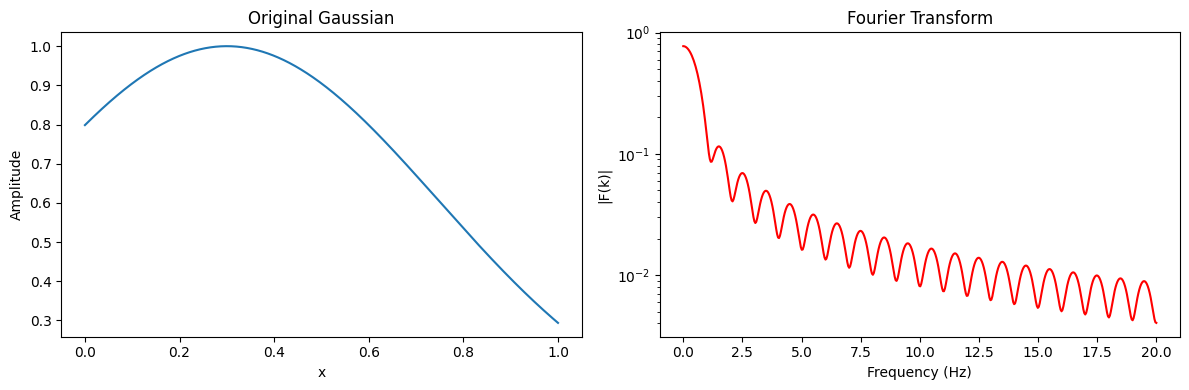

Standard gaussian: $G(x, \mu=0)$, Fourier transform  $\overline{G}(k) \rightarrow$ Gaussian 
Shifted gaussian: $G(x, \mu=b)$, Fourier transform $\overline{G}(k) \cdot e^{ikb} \rightarrow$ Oscillatory gaussian

In [56]:
analyser.plot_fourier_reference()

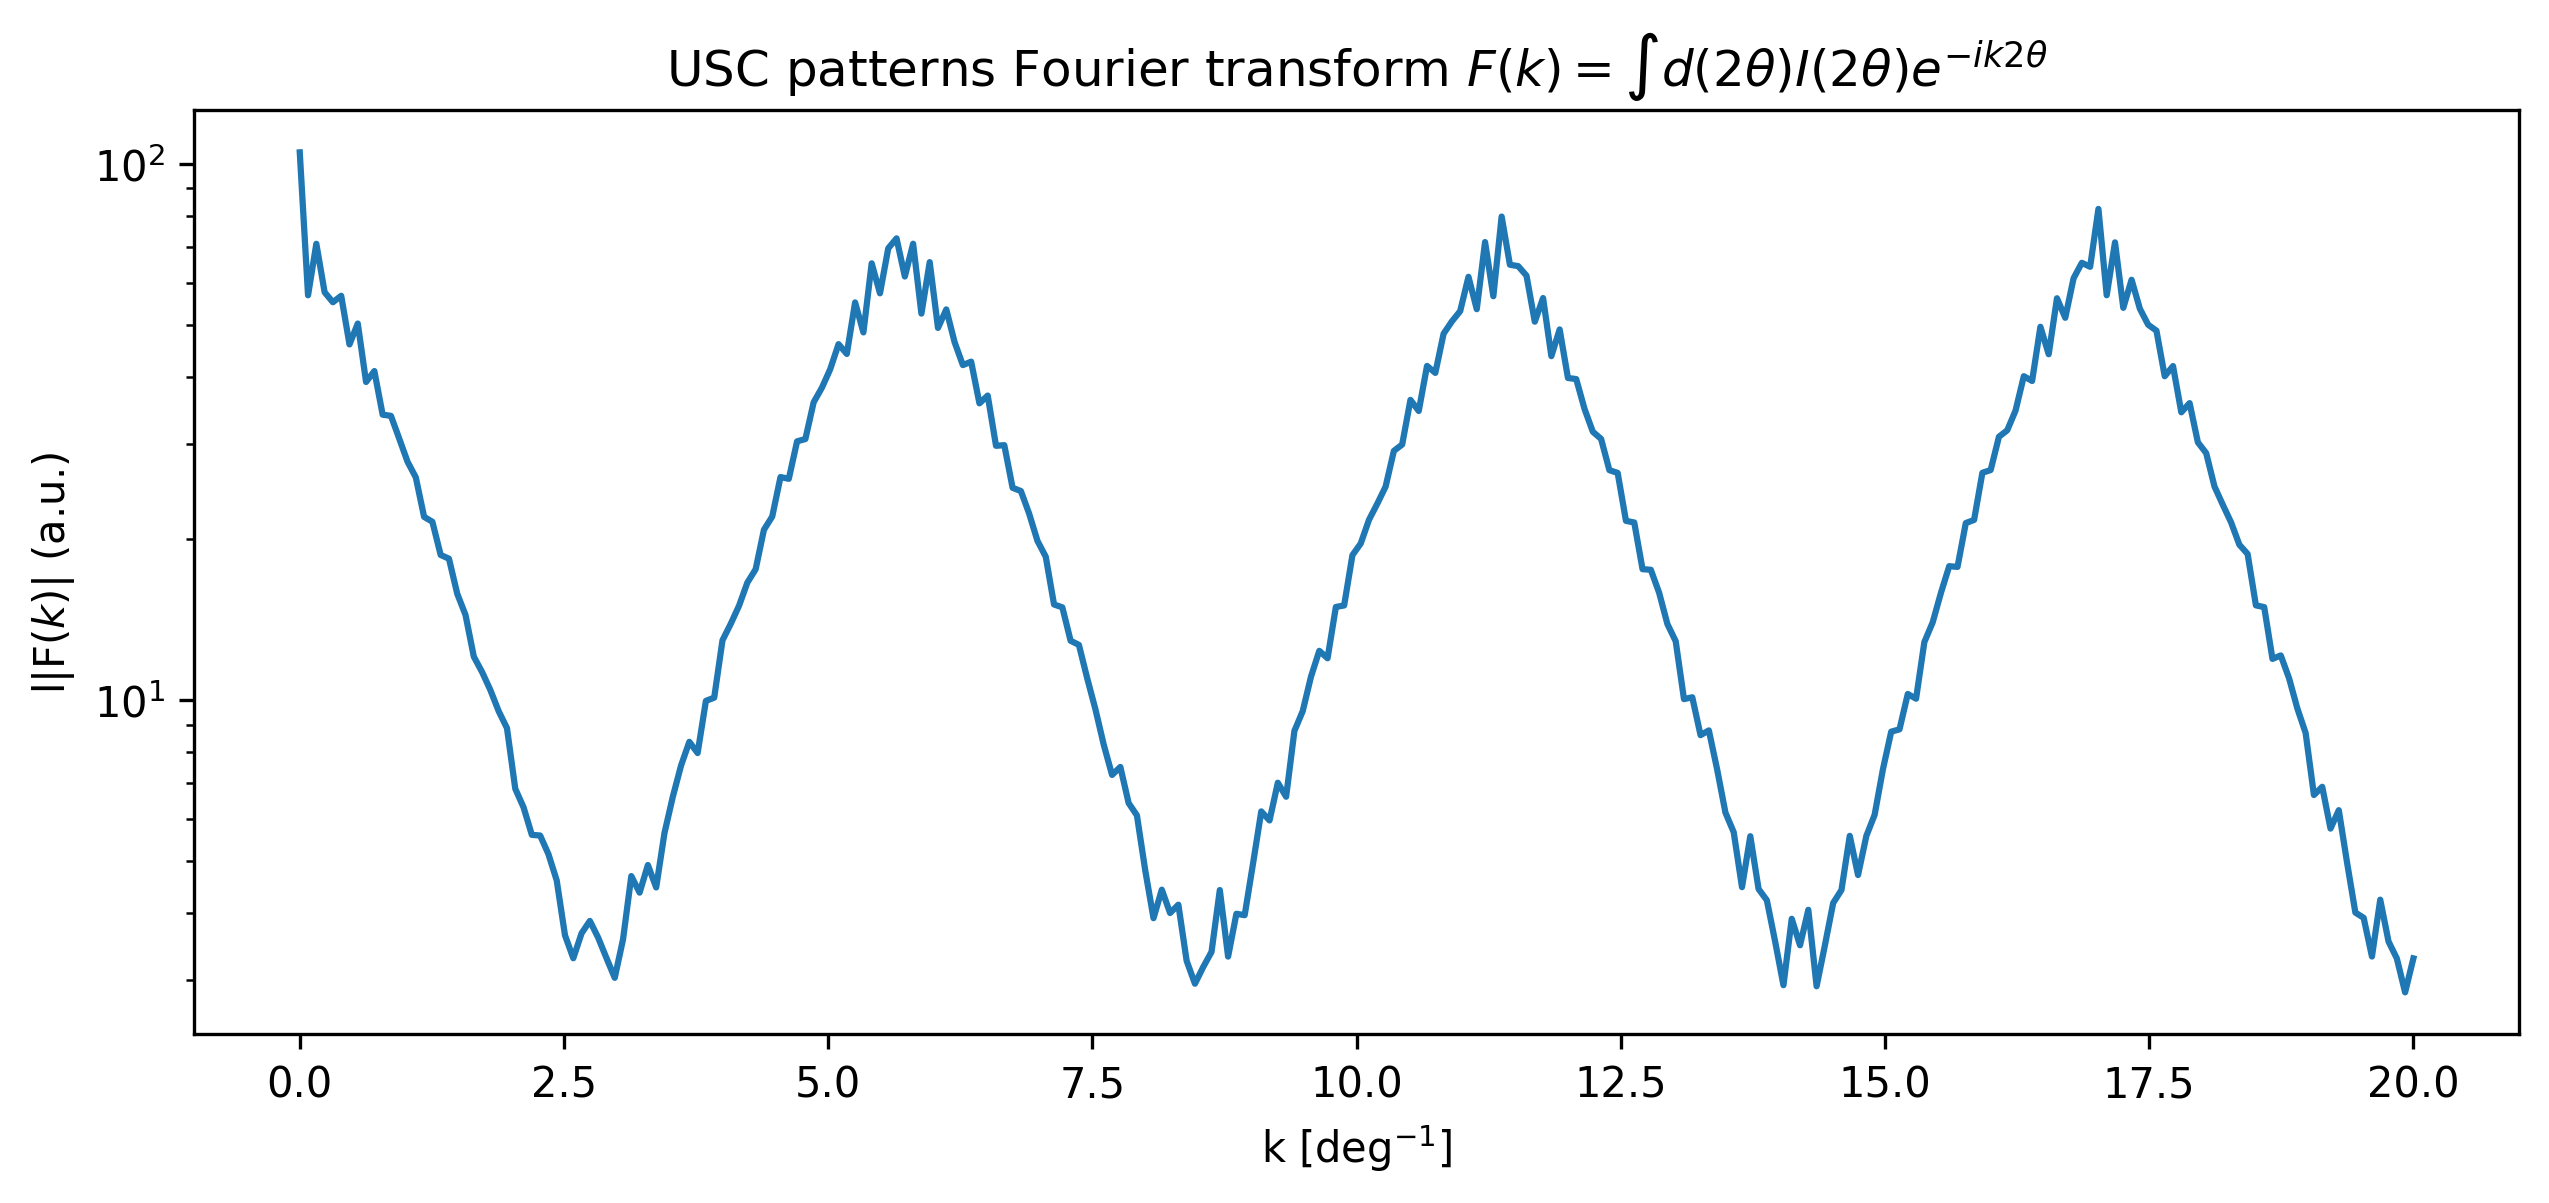

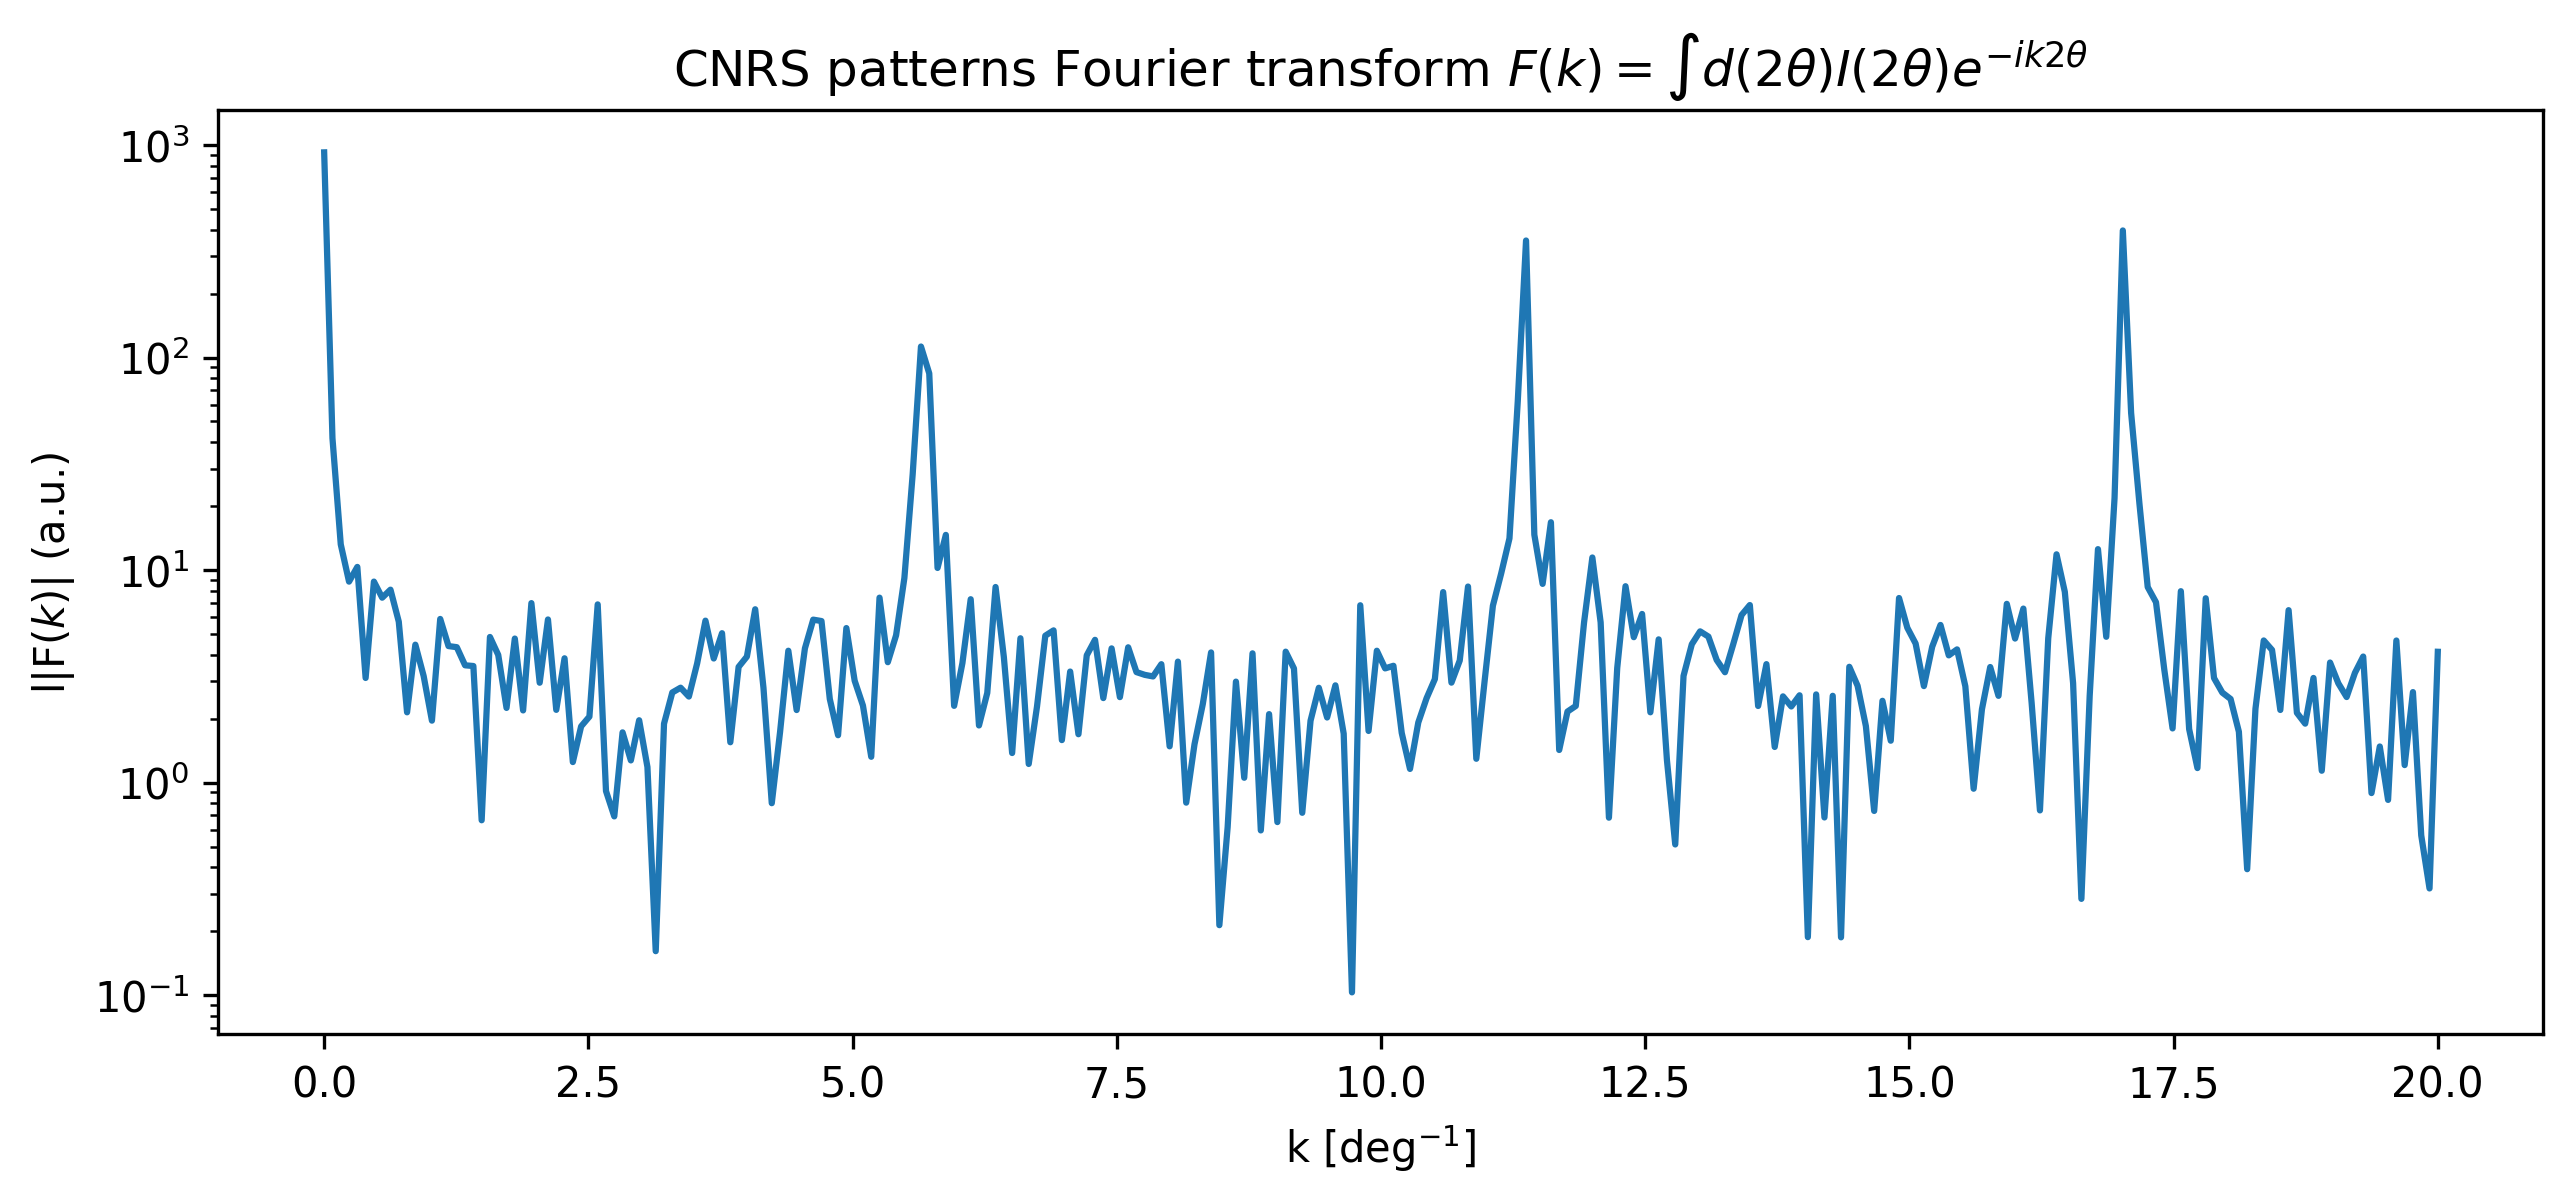

In [5]:
analyser.plot_fourier()

---> Combined pattern plot for databaes ['a:USC', 'b:CNRS'] | No. patterns = 10

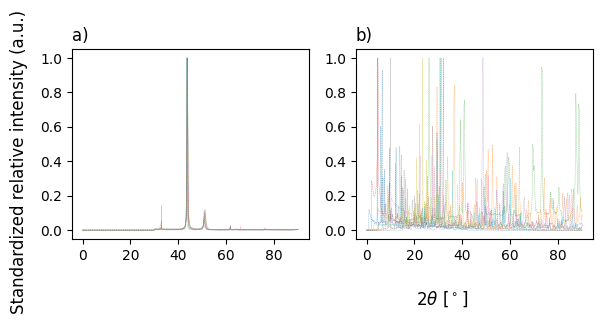

In [6]:
analyser.plot_in_single(limit_patterns=10)

---> Combined pattern plot for databaes ['a:USC', 'b:CNRS'] | No. patterns = 50

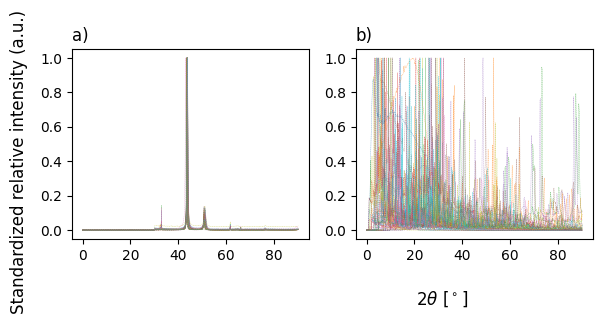

In [7]:
analyser.plot_in_single(limit_patterns=50)

---> Combined pattern plot for databaes ['a:USC', 'b:CNRS'] | No. patterns = 1000

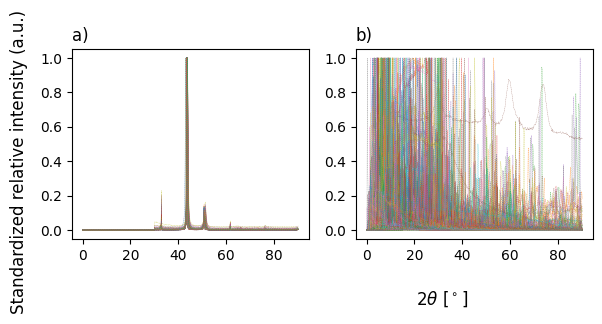

In [8]:
analyser.plot_in_single(limit_patterns=1000)

Cumulative explained variance ratio $v$ over components |  $v =  \frac{\sum_i \lambda_i}{\sum^n_{j=1} \lambda_j}$

[Debug]: Performing PCA for USC | No. patterns = 174
[Debug]: Performing PCA for CNRS | No. patterns = 210


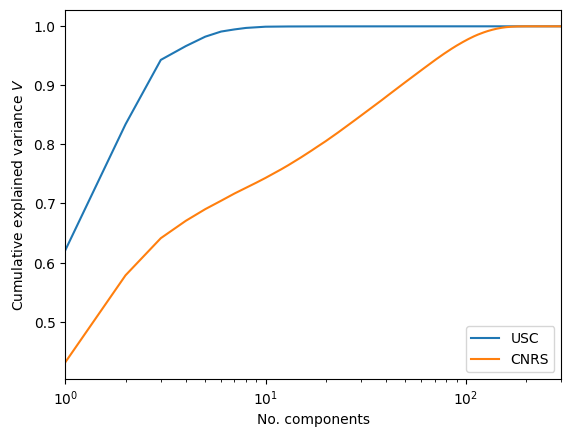

In [9]:
analyser.plot_effective_components()

---> Histogram of general information on opXRD

/home/daniel/aimat/xrdpattern/xrdpattern/pattern/visualization.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(spg_formulas, rotation=90)


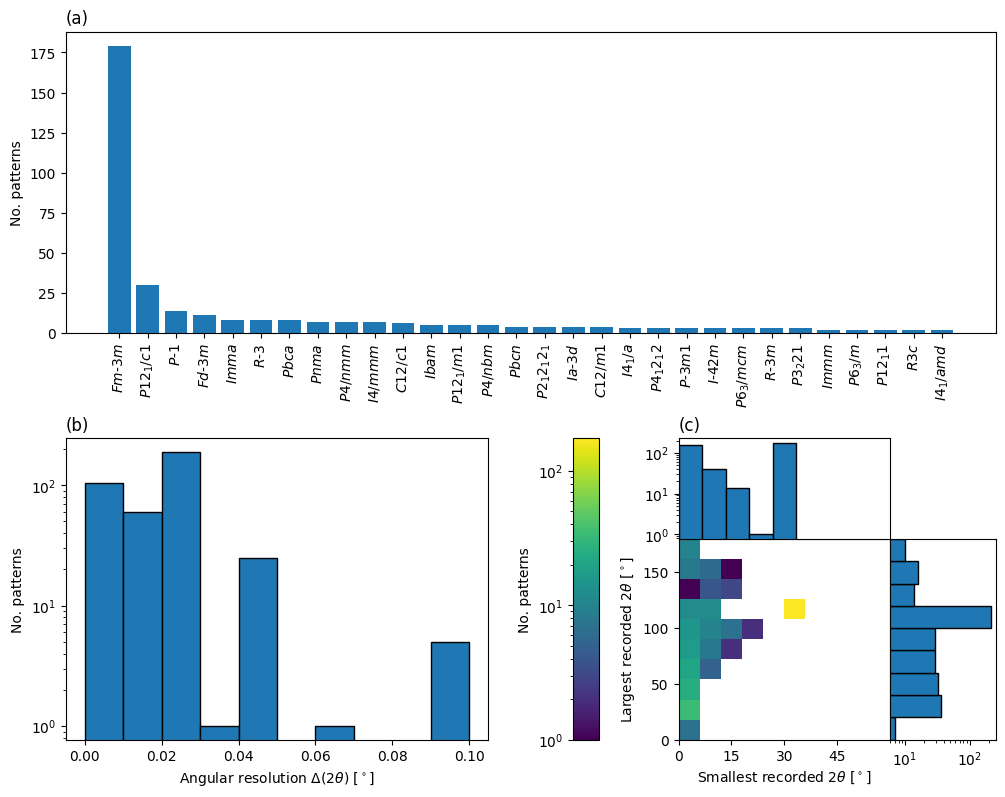

In [10]:
analyser.plot_histogram()

In [11]:
analyser.show_label_fractions()
analyser.print_total_counts()

---> Overview of label fractions per contribution

+------+-------+-----------+---------------+---------------+
|      |   spg |   lattice |   atom_coords |   composition |
|------+-------+-----------+---------------+---------------|
| USC  |     1 |  0.994253 |      0        |      1        |
| CNRS |     1 |  1        |      0.828571 |      0.828571 |
+------+-------+-----------+---------------+---------------+


---> Total pattern counts in opXRD

Total number of patterns = 384
Number of labeled patterns = 384
